<a href="https://colab.research.google.com/github/MRameezU/ISIC2017-Unet/blob/main/notebooks/isic_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 0- Get Setup

In [73]:
!pip install --upgrade torch
!pip install --upgrade torchvision

import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


device agnostic code

In [74]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1 - Gettting Data

### 1.0 - Downloading and Reorganizing training data

In [75]:
import requests
import zipfile
from pathlib import Path
from tqdm.notebook import tqdm
# training data
# path to data folder
data_path = Path("data/")
train_data_path = data_path / "train"
binary_mask_data_path = data_path / "binary"
train_zip_url = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip"
train_zip_file = data_path / "ISIC-2017_Training_Data.zip"
# binary mask
train_binary_zip_url = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip"
train_binary_zip_file = data_path / "ISIC-2017_Training_Part1_GroundTruth.zip"



def download_file(url, dest_path):
    """Downloads a file from a URL to a destination path with progress bar."""
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an error for bad responses
    total_size = int(response.headers.get('content-length', 0))
    with open(dest_path, "wb") as file, tqdm(
        desc=f"Downloading {dest_path.name}",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
            bar.update(len(chunk))
    print(f"Download Complete: {dest_path}")

def extract_zip(file_path, extract_to):
    """Extracts a zip file to the specified directory."""
    with zipfile.ZipFile(file_path, mode="r") as zip_file:
        print(f"Extracting {file_path.name} to {extract_to}")
        zip_file.extractall(extract_to)
    print(f"Extraction Complete: {extract_to}")


In [76]:
# Main script
if train_data_path.is_dir() and binary_mask_data_path.is_dir():
    print(f"{train_data_path} and {binary_mask_data_path} directories already exist.")
else:
    print(f"Preparing data directories at {data_path}")
    train_data_path.mkdir(parents=True, exist_ok=True)

    # Download training data
    print(f"Downloading Training Data from: {train_zip_url}")
    download_file(train_zip_url, train_zip_file)

    # Extract the zip file
    extract_zip(train_zip_file, train_data_path)

    binary_mask_data_path.mkdir(parents=True,exist_ok=True)
    # Download training data
    print(f"Downloading Binary Mask Data from: {train_binary_zip_url}")
    download_file(train_binary_zip_url, train_binary_zip_file)

    # Extract the zip file
    extract_zip(train_binary_zip_file, binary_mask_data_path)

Preparing data directories at data


Download Complete: data/ISIC-2017_Training_Data.zip
Extracting ISIC-2017_Training_Data.zip to data/train
Extraction Complete: data/train


Download Complete: data/ISIC-2017_Training_Part1_GroundTruth.zip
Extracting ISIC-2017_Training_Part1_GroundTruth.zip to data/binary
Extraction Complete: data/binary


the data contain the Images and their respective Superpixel mask and we have to download Binary mask seperately

#### Seperating the Inputs and Ouputs
our train data folder contain both Training Images and SuperPixel mask therfore seperating them into different folders

In [77]:
import os
from pathlib import Path
import shutil


def organize_files(dataset_folder, image_output_folder, superpixel_output_folder):
    """
    Organize files by separating images and superpixel masks into different folders.

    Args:
        dataset_folder (str or Path): Path to the folder containing both images and masks.
        image_output_folder (str or Path): Path to the folder where images will be moved.
        superpixel_output_folder (str or Path): Path to the folder where superpixel masks will be moved.
    """
    # Convert paths to Path objects
    dataset_folder = Path(dataset_folder)
    image_output_folder = Path(image_output_folder)
    superpixel_output_folder = Path(superpixel_output_folder)

    # Create output folders if they don't exist
    image_output_folder.mkdir(parents=True, exist_ok=True)
    superpixel_output_folder.mkdir(parents=True, exist_ok=True)

    # Iterate through all files in the dataset folder
    for file in dataset_folder.iterdir():
        if file.is_file():
            if file.name.endswith(".jpg"):
                # Move image file
                shutil.move(str(file), str(image_output_folder / file.name))
            elif file.name.endswith("_superpixels.png"):
                # Move superpixel mask file
                shutil.move(str(file), str(superpixel_output_folder / file.name))

    print(f"Files have been organized. Images moved to {image_output_folder}, masks to {superpixel_output_folder}.")

if __name__ == "__main__":
    dataset_folder=train_data_path / "ISIC-2017_Training_Data"   #"data/train/ISIC-2017_Data"
    image_output_folder="ISIC-2017_Data/train/Images"
    superpixel_output_folder="ISIC-2017_Data/train/Superpixel"

    organize_files(dataset_folder=dataset_folder,
                   image_output_folder=image_output_folder,
                   superpixel_output_folder=superpixel_output_folder)


Files have been organized. Images moved to ISIC-2017_Data/train/Images, masks to ISIC-2017_Data/train/Superpixel.


Moving Binary masks

In [78]:
import shutil
# moving file to a consolidated location
source_dir = binary_mask_data_path / "ISIC-2017_Training_Part1_GroundTruth" #Path("data/train/ISIC-2017_Training_Part1_GroundTruth")
destination_dir = Path("ISIC-2017_Data/train/Binary")
# Create the destination directory if it doesn't exist
destination_dir.mkdir(parents=True, exist_ok=True)
for file in source_dir.iterdir():
  if file.is_file():
    shutil.move(str(file),str(destination_dir/file.name))

#### Deleting the Extras
Deleting the `data_path` folder to save storage

In [79]:
# Deleting our data_path after getting our desizerd ouput to free storage
if data_path.exists() and data_path.is_dir():
    shutil.rmtree(data_path)
    print(f"Folder '{data_path}' and all its subdirectories have been deleted.")
else:
    print(f"Folder '{data_path}' does not exist.")

Folder 'data' and all its subdirectories have been deleted.


#### Result
 ISIC-2017_Data This folder contains the dataset for the ISIC 2017 skin cancer segmentation project. The dataset is organized into the following subfolders:
 ## Structure

### Subfolders

1. **Images/**
   - Contains the original images used for training and validation.

2. **Superpixel/**
   - Contains the superpixel masks generated for each image.

3. **Binary/**
   - Contains the binary masks indicating the regions of interest in each image.


### 1.1 - Downloading reorganizing Validation data

In [80]:
# path to data folder
data_path = Path("data/")
validaiton_data_path = data_path / "valid"
binary_mask_data_path = data_path / "binary"
valid_zip_url = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Data.zip"
valid_zip_file = data_path / "ISIC-2017_Validation_Data.zip"
# binary mask
valid_binary_zip_url = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Part1_GroundTruth.zip"
valid_binary_zip_file = data_path / "ISIC-2017_Training_Part1_GroundTruth.zip"



In [81]:
if validaiton_data_path.is_dir() and binary_mask_data_path.is_dir():
    print(f"{validaiton_data_path} and {binary_mask_data_path} directories already exist.")
else:
    print(f"Preparing data directories at {data_path}")
    validaiton_data_path.mkdir(parents=True, exist_ok=True)

    # Download training data
    print(f"Downloading validation Data from: {valid_zip_url}")
    download_file(valid_zip_url, valid_zip_file)

    # Extract the zip file
    extract_zip(valid_zip_file, validaiton_data_path)

    binary_mask_data_path.mkdir(parents=True,exist_ok=True)
    # Download training data
    print(f"Downloading Binary Mask Data from: {train_binary_zip_url}")
    download_file(valid_binary_zip_url, valid_binary_zip_file)

    # Extract the zip file
    extract_zip(valid_binary_zip_file, binary_mask_data_path)

Preparing data directories at data


Download Complete: data/ISIC-2017_Validation_Data.zip
Extracting ISIC-2017_Validation_Data.zip to data/valid
Extraction Complete: data/valid


Download Complete: data/ISIC-2017_Training_Part1_GroundTruth.zip
Extracting ISIC-2017_Training_Part1_GroundTruth.zip to data/binary
Extraction Complete: data/binary


In [82]:
dataset_folder=validaiton_data_path / "ISIC-2017_Validation_Data"   #"/content/data/valid/ISIC-2017_Validation_Data"
image_output_folder="ISIC-2017_Data/valid/Images"
superpixel_output_folder="ISIC-2017_Data/valid/Superpixel"

organize_files(dataset_folder=dataset_folder,
                   image_output_folder=image_output_folder,
                   superpixel_output_folder=superpixel_output_folder)

Files have been organized. Images moved to ISIC-2017_Data/valid/Images, masks to ISIC-2017_Data/valid/Superpixel.


In [83]:
import shutil
# moving file to a consolidated location
source_dir = binary_mask_data_path / "ISIC-2017_Validation_Part1_GroundTruth" #Path("/content/data/binary/ISIC-2017_Validation_Part1_GroundTruth")
destination_dir = Path("ISIC-2017_Data/valid/Binary")
# Create the destination directory if it doesn't exist
destination_dir.mkdir(parents=True, exist_ok=True)
for file in source_dir.iterdir():
  if file.is_file():
    shutil.move(str(file),str(destination_dir/file.name))

In [84]:
# Deleting our data_path after getting our desizerd ouput to free storage
if data_path.exists() and data_path.is_dir():
    shutil.rmtree(data_path)
    print(f"Folder '{data_path}' and all its subdirectories have been deleted.")
else:
    print(f"Folder '{data_path}' does not exist.")

Folder 'data' and all its subdirectories have been deleted.


## 2 - Become one with the data (data preparation and exploration)

In [85]:
import os
def walk_through(dir_path:str):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [86]:
data_path=Path("ISIC-2017_Data")
walk_through(data_path)

There are 2 directories and 0 images in 'ISIC-2017_Data'.
There are 3 directories and 0 images in 'ISIC-2017_Data/valid'.
There are 0 directories and 150 images in 'ISIC-2017_Data/valid/Binary'.
There are 0 directories and 150 images in 'ISIC-2017_Data/valid/Superpixel'.
There are 0 directories and 150 images in 'ISIC-2017_Data/valid/Images'.
There are 3 directories and 0 images in 'ISIC-2017_Data/train'.
There are 0 directories and 2000 images in 'ISIC-2017_Data/train/Binary'.
There are 0 directories and 2000 images in 'ISIC-2017_Data/train/Superpixel'.
There are 0 directories and 2000 images in 'ISIC-2017_Data/train/Images'.


### 2.1 Visualize Images
Let's write some code to:

1. Get all of the image paths using `pathlib.Path.glob()` to find all of the files ending in .jpg.
2. Pick a random image path using Python's `random.choice()`.
3. And since we're working with images, we'll open the random image path using `PIL.Image.open()` (PIL stands for Python Image Library).


In [ ]:
import random
from PIL import Image

# creating a list of all the images
image_path_list=list(data_path.glob("**/*.jpg"))
len(image_path_list)

# select a random image path
random_image_path = random.choice(image_path_list)

# open Image
img = Image.open(fp=random_image_path)
print(f"Random Image Path: {random_image_path}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

# Display the image
img

In [91]:
random_images_path_idx=random.sample(population=range(len(image_path_list)),k=3)
random_images_path_idx

[1290, 802, 1729]

In [99]:
# list for inut images
image_path_list=sorted(list(data_path.glob("**/*.jpg")))
# list for binary masks
binary_mask_list=sorted(list(data_path.glob("**/Binary/*.png")))
# list for superpixel mask
superpixel_mask_list=sorted(list(data_path.glob("**/Superpixel/*.png")))
len(binary_mask_list),len(superpixel_mask_list)

(2150, 2150)

In [100]:
import random
from PIL import Image
import matplotlib.pyplot as plt
from typing import List

def plot_random_images(
    image_list: List[str],
    binary_mask_list: List[str],
    superpixel_mask_list: List[str],
    num_samples: int = 3
):
    """
    Plots a specified number of random images alongside their binary and superpixel masks.

    Args:
        image_list (List[str]): List of file paths to input images.
        binary_mask_list (List[str]): List of file paths to binary mask images.
        superpixel_mask_list (List[str]): List of file paths to superpixel mask images.
        num_samples (int, optional): Number of random samples to display. Defaults to 3.

    Raises:
        ValueError: If the lengths of `image_list`, `binary_mask_list`, and `superpixel_mask_list` are not equal.
        ValueError: If `num_samples` is greater than the number of available images.

    Example:
        ```python
        plot_random_images(
            image_list=["image1.jpg", "image2.jpg"],
            binary_mask_list=["binary1.png", "binary2.png"],
            superpixel_mask_list=["superpixel1.png", "superpixel2.png"],
            num_samples=2
        )
        ```
    """
    # Check for consistency in list lengths
    if len(image_list) != len(binary_mask_list) or len(image_list) != len(superpixel_mask_list):
        raise ValueError("All input lists must have the same length.")

    # Ensure the number of samples is valid
    if num_samples > len(image_list):
        raise ValueError("num_samples cannot be greater than the number of images available.")

    # Randomly sample indices
    idx = random.sample(range(len(image_list)), num_samples)

    # Create subplots
    fig, axes = plt.subplots(nrows=num_samples, ncols=3, figsize=(15, 5 * num_samples))

    # Ensure axes is a list of lists, even for single sample
    if num_samples == 1:
        axes = [axes]

    for i, sample_idx in enumerate(idx):
        # Open images and masks
        img = Image.open(image_list[sample_idx])
        superpixel_mask = Image.open(superpixel_mask_list[sample_idx])
        binary_mask = Image.open(binary_mask_list[sample_idx])

        # Plot the original image
        axes[i][0].imshow(img)
        axes[i][0].set_title(f"Image: {sample_idx},Size:{img.size}")
        axes[i][0].axis("off")

        # Plot the binary mask
        axes[i][1].imshow(binary_mask)
        axes[i][1].set_title(f"Binary Mask: {sample_idx},Size:{binary_mask.size}")
        axes[i][1].axis("off")

        # Plot the superpixel mask
        axes[i][2].imshow(superpixel_mask)
        axes[i][2].set_title(f"Superpixel Mask: {sample_idx},Size:{superpixel_mask.size}")
        axes[i][2].axis("off")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


In [ ]:
plot_random_images(image_list=image_path_list,
                   binary_mask_list=binary_mask_list,
                   superpixel_mask_list=superpixel_mask_list,
                   num_samples=3)

### 2.2 - Combining Masks
1. Weighted Average or Overlaying
2. Union
3. Intersection
4. Boundary Enhancement

In [102]:
import cv2
def load_masks(binary_mask_path_list, superpixel_mask_path_list,):
  # Randomly sample indices
  # Check for consistency in list lengths
  if len(binary_mask_path_list) != len(superpixel_mask_path_list):
      raise ValueError("The binary and superpixel mask lists must have the same length.")

  # Randomly select a single index
  idx = random.choice(range(len(binary_mask_path_list)))

  # Load masks as grayscale images
  binary_mask = cv2.imread(binary_mask_path_list[idx], cv2.IMREAD_GRAYSCALE)
  superpixel_mask = cv2.imread(superpixel_mask_path_list[idx], cv2.IMREAD_GRAYSCALE)

  return binary_mask, superpixel_mask

bm, sm = load_masks(
    binary_mask_path_list=binary_mask_list,
    superpixel_mask_path_list=superpixel_mask_list
)

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(bm)

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(sm)

### 2.3 - Weighted average or Overlaying

In [105]:
import cv2
import numpy as np
from pathlib import Path

def weighted_average_combination(binary_mask,superpixel_mask,alpha=0.5):
  # Normalize masks to range [0, 1]
  binary_mask = binary_mask.astype(np.float32) / 255.0
  superpixel_mask = superpixel_mask.astype(np.float32) / 255.0

  # Compute weighted average
  combined_mask = alpha * binary_mask + (1 - alpha) * superpixel_mask

  # Clip values to [0, 1] and scale back to [0, 255]
  combined_mask = np.clip(combined_mask, 0, 1)
  return (combined_mask * 255).astype(np.uint8)

In [ ]:
wac=weighted_average_combination(bm,sm)
cv2_imshow(wac)

lets try and overlay the orignal image with each mask and try to better understand our data

overlaying binary mask with orignal image

In [107]:
bm,img=load_masks(
    binary_mask_path_list=binary_mask_list,
    superpixel_mask_path_list=image_path_list,#insted of superpixel_mask_path_list we are send the image paths list
)

In [ ]:
cv2_imshow(img)

In [ ]:
wac=weighted_average_combination(bm,img)
cv2_imshow(wac)

overlaying subinaryperpixel mask with orignal image

In [110]:
img,sm=load_masks(
    binary_mask_path_list=image_path_list,#insted of binary_mask_path_list we are send the image paths list
    superpixel_mask_path_list=superpixel_mask_list)

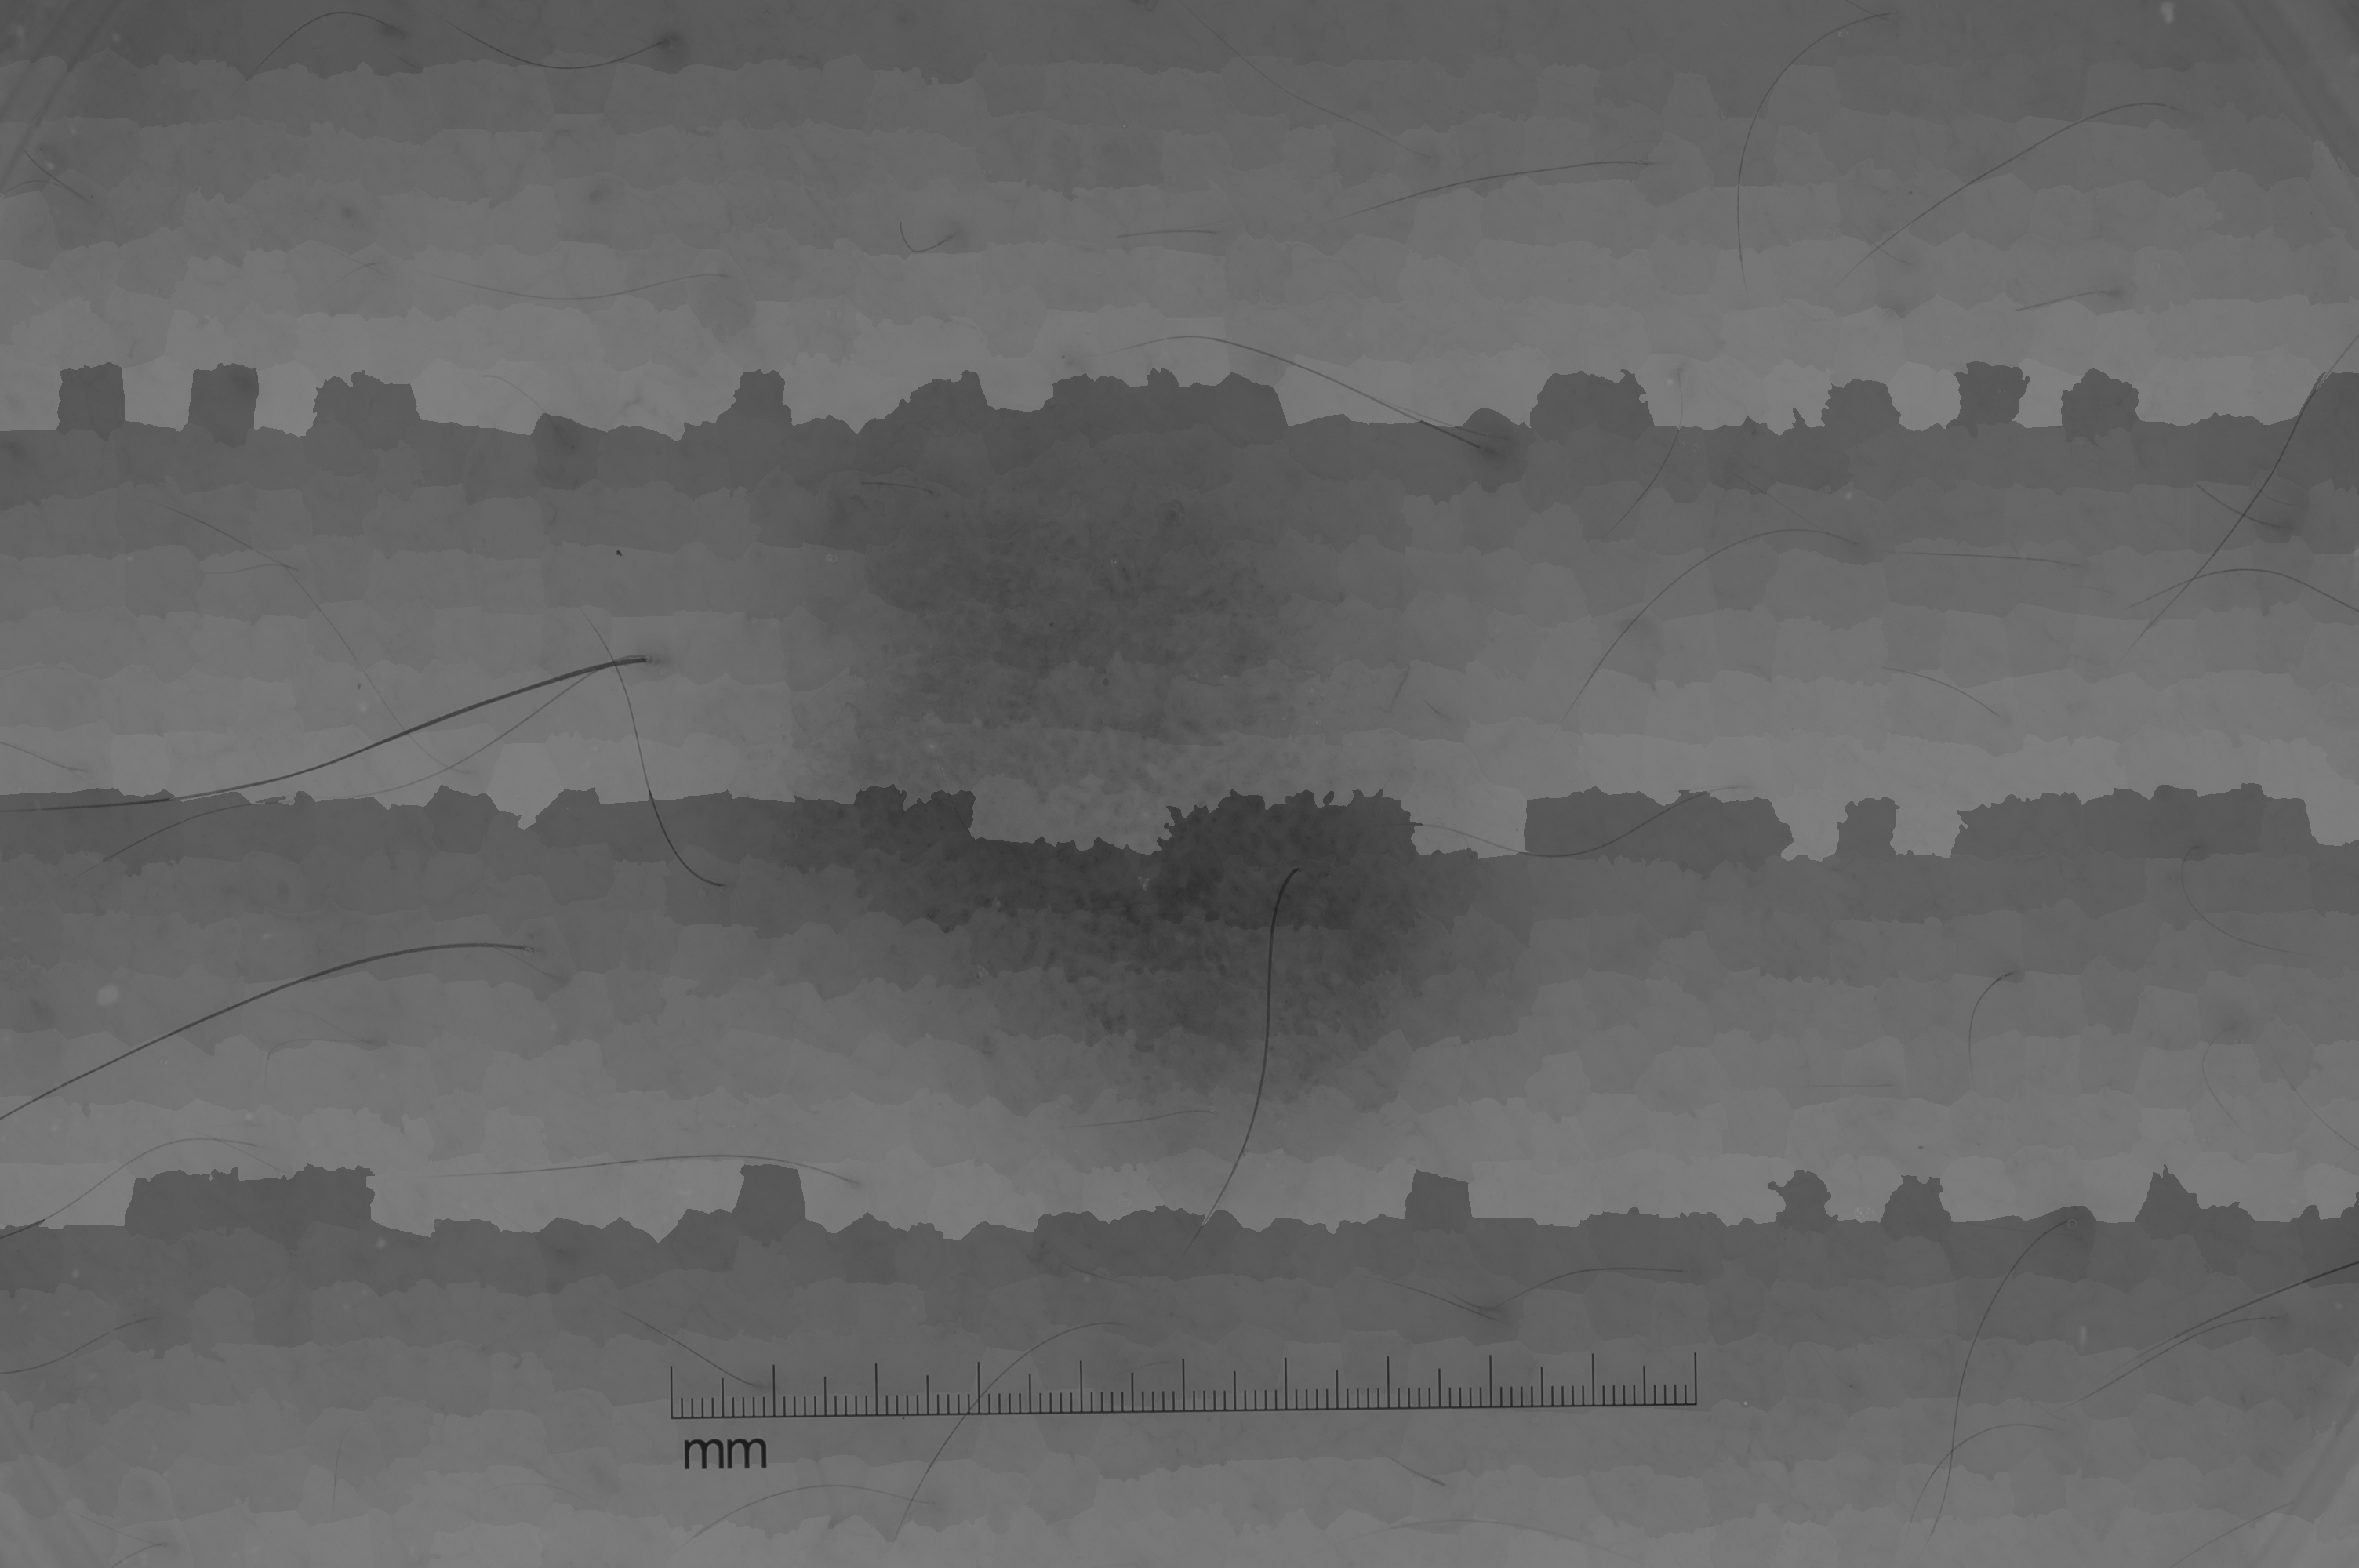

In [111]:
wac=weighted_average_combination(img,sm)
cv2_imshow(wac)

## 3 - Creating our (UNET) model class

In [112]:
from collections import OrderedDict
import torch
import torch.nn as nn

class UNET (nn.Module):
  def __init__(self,in_channels=3,out_channels=1,init_features=32):
    super().__init__()

    features=init_features
    self.encoder1=UNET._block(in_channels,features,name="encoder_1")
    self.pool1=nn.MaxPool2d(kernel_size=2,stride=2)
    self.encoder2=UNET._block(features,features*2,name="encoder_2")
    self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
    self.encoder3=UNET._block(features*2,features*4,name="encoder_3")
    self.pool3=nn.MaxPool2d(kernel_size=2,stride=2)
    self.encoder4=UNET._block(features*4,features*8,name="encoder_4")
    self.pool4=nn.MaxPool2d(kernel_size=2,stride=2)

    # bottle neck
    self.bottleneck=UNET._block(features*8,features*16,name="bottleneck")

    # Decoer
    self.upconv4=nn.ConvTranspose2d(in_channels=features*16,out_channels=features*8,kernel_size=2,stride=2)
    self.decoder4=UNET._block((features*8)*2,features*8,name="decoder_4")

    self.upconv3=nn.ConvTranspose2d(in_channels=features*8,out_channels=features*4,kernel_size=2,stride=2)
    self.decoder3=UNET._block((features*4)*2,features*4,name="decoder_3")

    self.upconv2=nn.ConvTranspose2d(in_channels=features*4,out_channels=features*2,kernel_size=2,stride=2)
    self.decoder2=UNET._block((features*2)*2,features*2,name="decoder_2")

    self.upconv1=nn.ConvTranspose2d(in_channels=features*2,out_channels=features,kernel_size=2,stride=2)
    self.decoder1=UNET._block(features*2,features,name="decoder_1")

    # output
    self.conv=nn.Conv2d(in_channels=features,out_channels=out_channels,kernel_size=1)

  def forward(self,x):
    # encoder
    encoder_1=self.encoder1(x)
    encoder_2=self.encoder2(self.pool1(encoder_1))
    encoder_3=self.encoder3(self.pool2(encoder_2))
    encoder_4=self.encoder4(self.pool3(encoder_3))
    # bottleneck
    bottleneck=self.bottleneck(self.pool4(encoder_4))
    # decoder
    decoder_4=self.upconv4(bottleneck)
    decoder_4=torch.cat((decoder_4,encoder_4),dim=1)
    decoder_4=self.decoder4(decoder_4)

    decoder_3=self.upconv3(decoder_4)
    decoder_3=torch.cat(tensors=(decoder_3,encoder_3),dim=1)
    decoder_3=self.decoder3(decoder_3)

    decoder_2=self.upconv2(decoder_3)
    decoder_2=torch.cat(tensors=(decoder_2,encoder_2),dim=1)
    decoder_2=self.decoder2(decoder_2)

    decoder_1=self.upconv1(decoder_2)
    decoder_1=torch.cat(tensors=(decoder_1,encoder_1),dim=1)
    decoder_1=self.decoder1(decoder_1)
    # final segmentation map
    return torch.sigmoid(self.conv(decoder_1))

  def _block(in_channels,features,name):

    seq=nn.Sequential(
        OrderedDict([
            (name + "conv1",nn.Conv2d(in_channels=in_channels,out_channels=features,kernel_size=3,padding=1,bias=False)),
            (name + "norm1",nn.BatchNorm2d(num_features=features)),
            (name + "relu1",nn.ReLU(inplace=True)),

            (name + "conv2",nn.Conv2d(in_channels=features,out_channels=features,kernel_size=3,padding=1,bias=False)),
            (name + "norm2",nn.BatchNorm2d(num_features=features)),
            (name + "relu2",nn.ReLU(inplace=True)),
        ])
    )
    return seq



💀 **Error Made**

 *What Happened with the Input Size of (244, 244)?*


>`# creating transform
  transform=transforms.Compose([transforms.Resize(size=(244,244)),
                                      transforms.ToTensor()])`"
                                      
                                      
When the input size was (244, 244), you encountered the error because the spatial dimension was not divisible by 16 (after 4 downsampling operations). Let's break it down:

1. Initial Input: 244x244
2. After 1st MaxPool: 244 / 2 = 122
3. After 2nd MaxPool: 122 / 2 = 61
4. After 3rd MaxPool: 61 / 2 = 30.5 (not an integer)

Since the dimensions after the pooling steps should always be integers, the fact that 244 / 2^4 = 15.25 (i.e., a non-integer) causes the model to fail, especially during upsampling, which uses a ConvTranspose2d (up-conv) layer that requires the output size to match the input size during concatenation."




In [113]:
# wil result in error
model_0=UNET()
dummy_in=torch.rand(size=(1,3,244,244))
output=model_0(dummy_in)
print(output)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 60 but got size 61 for tensor number 1 in the list.

🟢 **Error Corrected:**

*Why (224, 224) Works:*

> `transform=transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.ToTensor()])`

When you change the input size to (224, 224):

1. Initial Input: 224x224
2. After 1st MaxPool: 224 / 2 = 112
3. After 2nd MaxPool: 112 / 2 = 56
4. After 3rd MaxPool: 56 / 2 = 28
5. After 4th MaxPool: 28 / 2 = 14

Here, 224 is divisible by 16, meaning that after 4 downsampling operations, the spatial dimension (14x14) is compatible for the decoder's upsampling. The size of the feature maps at each stage remains consistent, and the skip connections can concatenate without issues.

In [114]:
# will not result in error
dummy_in=torch.rand(size=(1,3,224,224))
output=model_0(dummy_in)
print(output)

tensor([[[[0.5133, 0.4761, 0.4866,  ..., 0.4812, 0.5354, 0.3924],
          [0.4598, 0.6330, 0.4436,  ..., 0.3942, 0.5113, 0.4769],
          [0.3944, 0.3657, 0.5315,  ..., 0.4259, 0.5708, 0.4455],
          ...,
          [0.4781, 0.4729, 0.5115,  ..., 0.4735, 0.2908, 0.5486],
          [0.5788, 0.2308, 0.5051,  ..., 0.3954, 0.3107, 0.4294],
          [0.4633, 0.2759, 0.4140,  ..., 0.3828, 0.4362, 0.4409]]]],
       grad_fn=<SigmoidBackward0>)


### 3.1 Use `torchinfo` to get an idea of the shapes going through our model

In [115]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [116]:
summary(model=model_0,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
UNET                                     [1, 1, 224, 224]          --
├─Sequential: 1-1                        [1, 32, 224, 224]         --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 224, 224]         64
│    └─ReLU: 2-3                         [1, 32, 224, 224]         --
│    └─Conv2d: 2-4                       [1, 32, 224, 224]         9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 224, 224]         64
│    └─ReLU: 2-6                         [1, 32, 224, 224]         --
├─MaxPool2d: 1-2                         [1, 32, 112, 112]         --
├─Sequential: 1-3                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         18,432
│    └─BatchNorm2d: 2-8                  [1, 64, 112, 112]         128
│    └─ReLU: 2-9                         [1, 64, 112, 112]         --
│    └

## 4 - Custom Dataset

In [117]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from typing import Tuple,Dict,List
import torch
from pathlib import Path

class ISICDataset(Dataset):
  def __init__(self,image_dir_path,binarymasks_dir_path,transform=transforms.ToTensor()):
    self.image_paths=sorted(list(Path(image_dir_path).glob("*.jpg")))
    self.binarymask_paths=sorted(list(Path(binarymasks_dir_path).glob("*.png")))
    self.transform=transform

    assert len(self.image_paths) == len(self.binarymask_paths), (
            "Number of images and binary masks do not match."
        )

  def load_image(self,index:int)->Image.Image:
    image_path=self.image_paths[index]
    return Image.open(image_path)
  def load_binarymask(self,index:int)->Image.Image:
    binarymask_path=self.binarymask_paths[index]
    return Image.open(binarymask_path).convert("L")
  def __len__(self)->int:
    return len(self.image_paths)
  def __getitem__(self,index:int)->Tuple[torch.Tensor,torch.Tensor]:
    img=self.load_image(index)
    mask=self.load_binarymask(index)

    if self.transform:
      return self.transform(img),self.transform(mask)
    else:
      return img,mask

## 5 - Dataset and Dataloaders

In [118]:
# error transform
# transform=transforms.Compose([transforms.Resize(size=(244,244)),
#                                       transforms.ToTensor()])

# creating right transform
transform=transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.ToTensor()])

In [119]:
# creating our training datasets
train_dataset=ISICDataset(image_dir_path="ISIC-2017_Data/train/Images",binarymasks_dir_path="ISIC-2017_Data/train/Binary",transform=transform)
img,mask=train_dataset[0]
print(img.shape,mask.shape)

torch.Size([3, 224, 224]) torch.Size([1, 224, 224])


In [120]:
# creating our validation datasets
valid_dataset=ISICDataset(image_dir_path="ISIC-2017_Data/valid/Images",binarymasks_dir_path="ISIC-2017_Data/valid/Binary",transform=transform)
img,mask=valid_dataset[0]
print(img.shape,mask.shape)

torch.Size([3, 224, 224]) torch.Size([1, 224, 224])


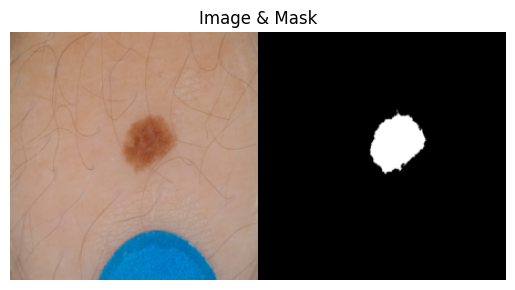

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Convert tensors to numpy arrays, resize mask to match image dimensions, and repeat mask channels
img = img.permute(1, 2, 0).numpy()
mask = mask.permute(1, 2, 0).squeeze().numpy()
mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

# Concatenate image and mask side by side
concatenated_img = np.concatenate((img, mask), axis=1)

# Display image and mask
plt.imshow(concatenated_img)
plt.title('Image & Mask', loc='center')
plt.axis('off')  # Remove axis ticks
plt.show()


In [122]:
len(train_dataset),len(valid_dataset)

(2000, 150)

In [123]:
# Creating dataloaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

train_dataloader=DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,
                            shuffle=True,num_workers=NUM_WORKERS,
                            pin_memory=True)
valid_dataloader=DataLoader(dataset=valid_dataset,batch_size=32,
                            shuffle=False,num_workers=NUM_WORKERS,
                            pin_memory=True)
train_dataloader,valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7df982de9b10>,
 <torch.utils.data.dataloader.DataLoader at 0x7df8c241f970>)

In [124]:
# checking our dataloaders
img,mask=next(iter(train_dataloader))

img.shape,mask.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1, 224, 224]))

## 6 - Create train and test


### 6.1 - Creating trainig and test step
* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `validation_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [125]:
try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics

In [128]:
def train_step(model:nn.Module,dataloader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,optimizer:torch.optim.Optimizer,
               acc_fn:torchmetrics.Accuracy,device):
  model.train()

  train_loss=0
  train_acc=0

  for batch,(img,mask) in enumerate(dataloader):
    img,mask = img.to(device),mask.to(device)

    # forward pass
    y_pred=model(img)

    # calculate the loss
    loss=loss_fn(y_pred,mask)
    train_loss += loss.item()
    # calculate acc
    acc=acc_fn((torch.sigmoid(y_pred)>0.5),mask)
    train_acc+=acc.item()

    # optimizer zero grad
    optimizer.zero_grad()
    # optimizer step
    optimizer.step()

  # calculate average loss and acc
  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)

  return train_loss,train_acc


def validation_step(model: nn.Module, dataloader: torch.utils.data.DataLoader,
                    loss_fn: nn.Module, acc_fn:torchmetrics.Accuracy,
                    device=device):
  # set model model to eval
  model.eval()

  # val loss and accuracy
  val_loss=0
  val_acc=0

  # turn off the gradeient tracking
  with torch.inference_mode():
    for batch,(img,mask) in enumerate(dataloader):
      img,mask=img.to(device),mask.to(device)

      # forward pass
      val_logits=model(img)
      # calculate the loss
      loss=loss_fn(val_logits,mask)
      val_loss+=loss

      acc=acc_fn((torch.sigmoid(val_logits)>0.5),mask)
      val_acc+=acc

    val_loss=val_loss/len(dataloader)
    val_acc=val_acc/len(dataloader)

    return val_loss,val_acc


### 6.2 - Creating `train()` to combine trainig and validation step

In [129]:
from tqdm.auto import tqdm

def train(model:nn.Module,train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,loss_fn:nn.Module,
          acc_fn:torchmetrics.Accuracy,epochs,device):
  results={"train_loss":[],
           "train_acc":[],
           "val_loss":[],
           "val_acc":[]}
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model,dataloader=train_dataloader,
                                    loss_fn=loss_fn,optimizer=optimizer,
                                    acc_fn=acc_fn,device=device)
    val_loss,val_acc=validation_step(model,dataloader=test_dataloader,
                                     loss_fn=loss_fn,acc_fn=acc_fn,
                                     device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | val loss: {val_loss:.4f} | val acc: {val_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)

  # 6. Return the filled results at the end of the epochs
  return results


## test loops

In [130]:
from tqdm.auto import tqdm
import torch

def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    acc_fn: torchmetrics.Accuracy,
    device,
    scaler: torch.cuda.amp.GradScaler,  # Added scaler for mixed precision
):
    model.train()

    train_loss = 0
    train_acc = 0

    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)

    for batch, (img, mask) in loop:
        img, mask = img.to(device), mask.to(device)

        # Forward pass with mixed precision
        with torch.cuda.amp.autocast():
            y_pred = model(img)
            loss = loss_fn(y_pred, mask)

        train_loss += loss.item()

        # Calculate accuracy
        train_acc += acc_fn((torch.sigmoid(y_pred) > 0.5), mask).item()

        # Backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update tqdm progress bar
        loop.set_postfix(loss=loss.item())

    # Calculate average loss and accuracy
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def validation_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.Accuracy,
    device,
):
    model.eval()

    val_loss = 0
    val_acc = 0

    # Turn off gradient tracking
    with torch.inference_mode():
        for batch, (img, mask) in enumerate(dataloader):
            img, mask = img.to(device), mask.to(device)

            # Forward pass
            val_logits = model(img)
            loss = loss_fn(val_logits, mask)
            val_loss += loss.item()

            # Calculate accuracy
            val_acc += acc_fn((torch.sigmoid(val_logits) > 0.5), mask).item()

    # Calculate average loss and accuracy
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    return val_loss, val_acc


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.Accuracy,
    epochs: int,
    device,
):
    # Initialize GradScaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in tqdm(range(epochs)):
        print(f"\nEpoch {epoch + 1}/{epochs}:")

        # Training step
        train_loss, train_acc = train_step(
            model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            acc_fn=acc_fn,
            device=device,
            scaler=scaler,
        )

        # Validation step
        val_loss, val_acc = validation_step(
            model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )

        # Save periodic checkpoints
        if epoch % 5 == 0 and epoch != 0:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
            }
            torch.save(checkpoint, f"checkpoint_epoch_{epoch}.pth.tar")

        # Log epoch results
        print(
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # Save the final checkpoint
    torch.save(
        {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epochs,
        },
        "final_checkpoint.pth.tar",
    )

    return results


## 7 - Configuring model for training

In [131]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Epochs=25

model_0=UNET(in_channels=3,out_channels=1).to(device)
loss_fn=torch.nn.BCEWithLogitsLoss
optimizer=torch.optim.Adam(model_0.parameters(),lr=0.001)
scaler=torch.cuda.amp.GradScaler
acc_fn=torchmetrics.Accuracy(task="binary").to(device)

In [132]:
import torch
import torch.nn as nn

def setup_device_and_train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.Accuracy,
    epochs: int,
):
    """
    Sets up the device, enables multi-GPU support if available, and trains the model.

    Args:
        model (nn.Module): The model to train.
        train_dataloader (torch.utils.data.DataLoader): DataLoader for training data.
        test_dataloader (torch.utils.data.DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        loss_fn (nn.Module): Loss function.
        acc_fn (torchmetrics.Accuracy): Accuracy function.
        epochs (int): Number of training epochs.
    """
    # Check for available GPUs
    if torch.cuda.device_count() > 1:
        print(f"Multiple GPUs detected: {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)  # Wrap model for multi-GPU training
        device = torch.device("cuda:0")  # Primary GPU for coordination
    elif torch.cuda.is_available():
        print("Using a single GPU")
        device = torch.device("cuda:0")
    else:
        print("No GPU detected, using CPU")
        device = torch.device("cpu")

    # Move model to the appropriate device
    model = model.to(device)

    # Start training
    results = train(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        acc_fn=acc_fn,
        epochs=epochs,
        device=device,
    )

    return results


In [133]:
results=setup_device_and_train(model_0,train_dataloader,valid_dataloader,optimizer,loss_fn,acc_fn,2)

No GPU detected, using CPU


<ipython-input-130-c6779da5c984>:92: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]


Epoch 1/2:


  0%|          | 0/63 [00:00<?, ?it/s]

<ipython-input-130-c6779da5c984>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


RuntimeError: Boolean value of Tensor with more than one value is ambiguous